In [ ]:
# Step 1: Install and Load Required Libraries
if(!require(tidyverse)) install.packages("tidyverse", repos = "http://cran.us.r-project.org")
if(!require(caret)) install.packages("caret", repos = "http://cran.us.r-project.org")

library(tidyverse)
library(caret)


Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: caret

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘caret’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘ite

In [43]:
# Step 2: Download the Movielens 10M Dataset
options(timeout = 120)

dl <- "ml-10M100K.zip"
if (!file.exists(dl)) {
  download.file("https://files.grouplens.org/datasets/movielens/ml-10m.zip", dl)
}


In [44]:

# Step 3: Unzip and Load the Data
ratings_file <- "ml-10M100K/ratings.dat"
if(!file.exists(ratings_file))
  unzip(dl, ratings_file)

movies_file <- "ml-10M100K/movies.dat"
if(!file.exists(movies_file))
  unzip(dl, movies_file)

In [45]:

# Step 4: Read and Process the Ratings Data
ratings <- as.data.frame(str_split(read_lines(ratings_file), fixed("::"), simplify = TRUE),
                         stringsAsFactors = FALSE)
colnames(ratings) <- c("userId", "movieId", "rating", "timestamp")
ratings <- ratings %>%
  mutate(userId = as.integer(userId),
         movieId = as.integer(movieId),
         rating = as.numeric(rating),
         timestamp = as.integer(timestamp))


In [46]:

# Step 5: Read and Process the Movies Data
movies <- as.data.frame(str_split(read_lines(movies_file), fixed("::"), simplify = TRUE),
                        stringsAsFactors = FALSE)
colnames(movies) <- c("movieId", "title", "genres")
movies <- movies %>%
  mutate(movieId = as.integer(movieId))


# Step 6: Merge Ratings and Movies Data
movielens <- left_join(ratings, movies, by = "movieId")


In [47]:


# Step 7: Create `edx` and `final_holdout_test` Sets
set.seed(1, sample.kind = "Rounding")  # Use sample.kind = "Rounding" for R 3.6 or later
# set.seed(1)  # For R 3.5 or earlier

# Split the data: 10% for final holdout test, 90% for edx
test_index <- createDataPartition(y = movielens$rating, times = 1, p = 0.1, list = FALSE)
edx <- movielens[-test_index, ]
temp <- movielens[test_index, ]


Warning message in set.seed(1, sample.kind = "Rounding"):
“non-uniform 'Rounding' sampler used”


In [48]:

# Ensure that userId and movieId in the final holdout set are also present in the edx set
final_holdout_test <- temp %>%
  semi_join(edx, by = "movieId") %>%
  semi_join(edx, by = "userId")

# Add back rows that were removed from final holdout test set to the edx set
removed <- anti_join(temp, final_holdout_test)
edx <- rbind(edx, removed)

# Clean up
rm(dl, ratings, movies, test_index, temp, movielens, removed)


Joining with `by = join_by(userId, movieId, rating, timestamp, title, genres)`


In [49]:

# Display Summary of `edx` and `final_holdout_test`
cat("Number of rows in edx:", nrow(edx), "\n")
cat("Number of rows in final_holdout_test:", nrow(final_holdout_test), "\n")
cat("Number of unique users in edx:", length(unique(edx$userId)), "\n")
cat("Number of unique movies in edx:", length(unique(edx$movieId)), "\n")
cat("Number of unique users in final_holdout_test:", length(unique(final_holdout_test$userId)), "\n")
cat("Number of unique movies in final_holdout_test:", length(unique(final_holdout_test$movieId)), "\n")

# Preview the edx dataset
#head(edx)
glimpse(edx)

Number of rows in edx: 9000055 
Number of rows in final_holdout_test: 999999 
Number of unique users in edx: 69878 
Number of unique movies in edx: 10677 
Number of unique users in final_holdout_test: 68534 
Number of unique movies in final_holdout_test: 9809 
Rows: 9,000,055
Columns: 6
$ userId    <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, …
$ movieId   <int> 122, 185, 292, 316, 329, 355, 356, 362, 364, 370, 377, 420, …
$ rating    <dbl> 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, …
$ timestamp <int> 838985046, 838983525, 838983421, 838983392, 838983392, 83898…
$ title     <chr> "Boomerang (1992)", "Net, The (1995)", "Outbreak (1995)", "S…
$ genres    <chr> "Comedy|Romance", "Action|Crime|Thriller", "Action|Drama|Sci…


In [50]:
edx %>% summarize(unique_users = length(unique(userId)),
                  unique_movies = length(unique(movieId)),
                  unique_genres = length(unique(genres)))

unique_users,unique_movies,unique_genres
<int>,<int>,<int>
69878,10677,797


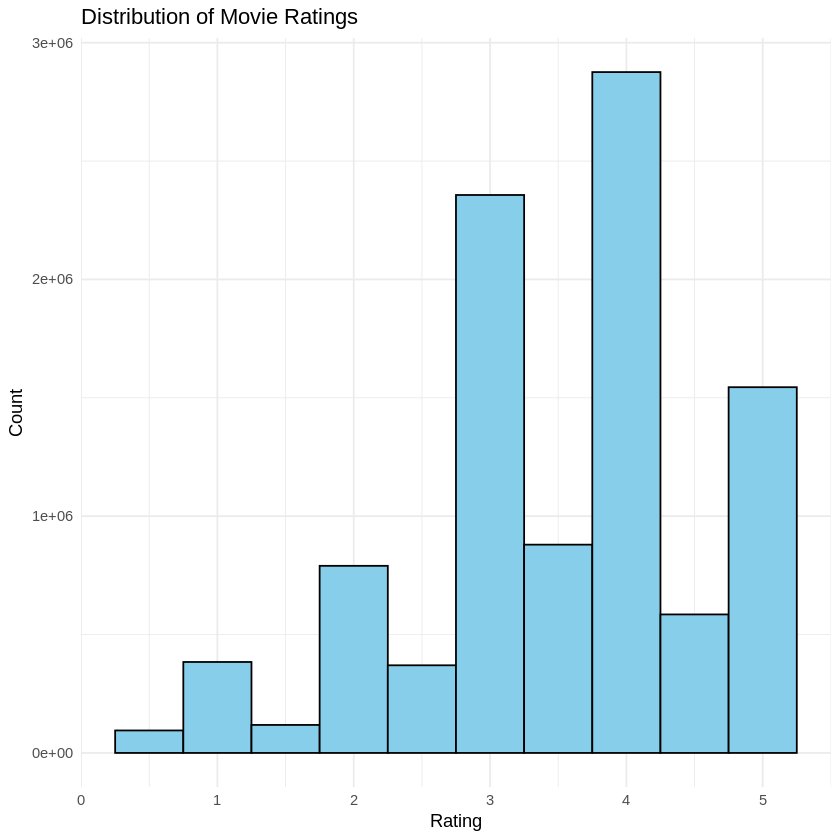

In [51]:
#RATINGS
ratings <- as.data.frame(str_split(read_lines("ml-10M100K/ratings.dat"), fixed("::"), simplify = TRUE), stringsAsFactors = FALSE)
colnames(ratings) <- c("userId", "movieId", "rating", "timestamp")
ratings <- ratings %>%
  mutate(userId = as.integer(userId),
         movieId = as.integer(movieId),
         rating = as.numeric(rating),
         timestamp = as.integer(timestamp))

# Plot 1: Histogram of Ratings Distribution
ggplot(ratings, aes(x = rating)) +
  geom_histogram(binwidth = 0.5, fill = "skyblue", color = "black") +
  labs(title = "Distribution of Movie Ratings", x = "Rating", y = "Count") +
  theme_minimal()


In [52]:
# Calculate the number of ratings greater than or equal to 3
rp <- edx %>% filter(rating >= 3)

# Calculate the proportion of such ratings
proportion <- nrow(rp) / nrow(edx)
cat("Proportion of ratings >= 3:", round(proportion, 4), "\n")


Proportion of ratings >= 3: 0.8242 


In [53]:
#TIMESTAMP
# Load required packages
if (!require(lubridate)) install.packages("lubridate", repos = "http://cran.us.r-project.org")
library(lubridate)

# Convert the timestamp to a readable date format and extract the year
edx <- edx %>%
  mutate(RatingDate = as.POSIXct(timestamp, origin = "1970-01-01"),
         RatingYear = year(RatingDate))

# Convert the timestamp in the validation_set to RatingDate and extract RatingYear
validation_set <- validation_set %>%
  mutate(RatingDate = as.POSIXct(timestamp, origin = "1970-01-01"),
         RatingYear = year(RatingDate))

# Preview the updated edx dataset
cat("edx dataset preview:\n")
head(edx)

# Preview the updated validation_set dataset
cat("\nvalidation_set dataset preview:\n")
head(validation_set)

edx dataset preview:


,userId,movieId,rating,timestamp,title,genres,RatingDate,RatingYear
,<int>,<int>,<dbl>,<int>,<chr>,<chr>,<dttm>,<dbl>
1,1,122,5,838985046,Boomerang (1992),Comedy|Romance,1996-08-02 11:24:06,1996
2,1,185,5,838983525,"Net, The (1995)",Action|Crime|Thriller,1996-08-02 10:58:45,1996
4,1,292,5,838983421,Outbreak (1995),Action|Drama|Sci-Fi|Thriller,1996-08-02 10:57:01,1996
5,1,316,5,838983392,Stargate (1994),Action|Adventure|Sci-Fi,1996-08-02 10:56:32,1996
6,1,329,5,838983392,Star Trek: Generations (1994),Action|Adventure|Drama|Sci-Fi,1996-08-02 10:56:32,1996
7,1,355,5,838984474,"Flintstones, The (1994)",Children|Comedy|Fantasy,1996-08-02 11:14:34,1996



validation_set dataset preview:


,userId,movieId,rating,timestamp,title,genres,RatingDate,RatingYear
,<int>,<int>,<dbl>,<int>,<chr>,<chr>,<dttm>,<dbl>
1,1,122,5,838985046,Boomerang (1992),Comedy|Romance,1996-08-02 11:24:06,1996
17,1,539,5,838984068,Sleepless in Seattle (1993),Comedy|Drama|Romance,1996-08-02 11:07:48,1996
29,2,648,2,868244699,Mission: Impossible (1996),Action|Adventure|Mystery|Thriller,1997-07-07 03:04:59,1997
31,2,733,3,868244562,"Rock, The (1996)",Action|Adventure|Thriller,1997-07-07 03:02:42,1997
33,2,780,3,868244698,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|War,1997-07-07 03:04:58,1997
48,3,1246,4,1133570967,Dead Poets Society (1989),Drama,2005-12-03 00:49:27,2005


In [54]:
range(edx$RatingYear)

[1] 1995 2009

'data.frame':	9000055 obs. of  8 variables:
 $ userId    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ movieId   : int  122 185 292 316 329 355 356 362 364 370 ...
 $ rating    : num  5 5 5 5 5 5 5 5 5 5 ...
 $ timestamp : int  838985046 838983525 838983421 838983392 838983392 838984474 838983653 838984885 838983707 838984596 ...
 $ title     : chr  "Boomerang (1992)" "Net, The (1995)" "Outbreak (1995)" "Stargate (1994)" ...
 $ genres    : chr  "Comedy|Romance" "Action|Crime|Thriller" "Action|Drama|Sci-Fi|Thriller" "Action|Adventure|Sci-Fi" ...
 $ RatingDate: POSIXct, format: "1996-08-02 11:24:06" "1996-08-02 10:58:45" ...
 $ RatingYear: num  1996 1996 1996 1996 1996 ...


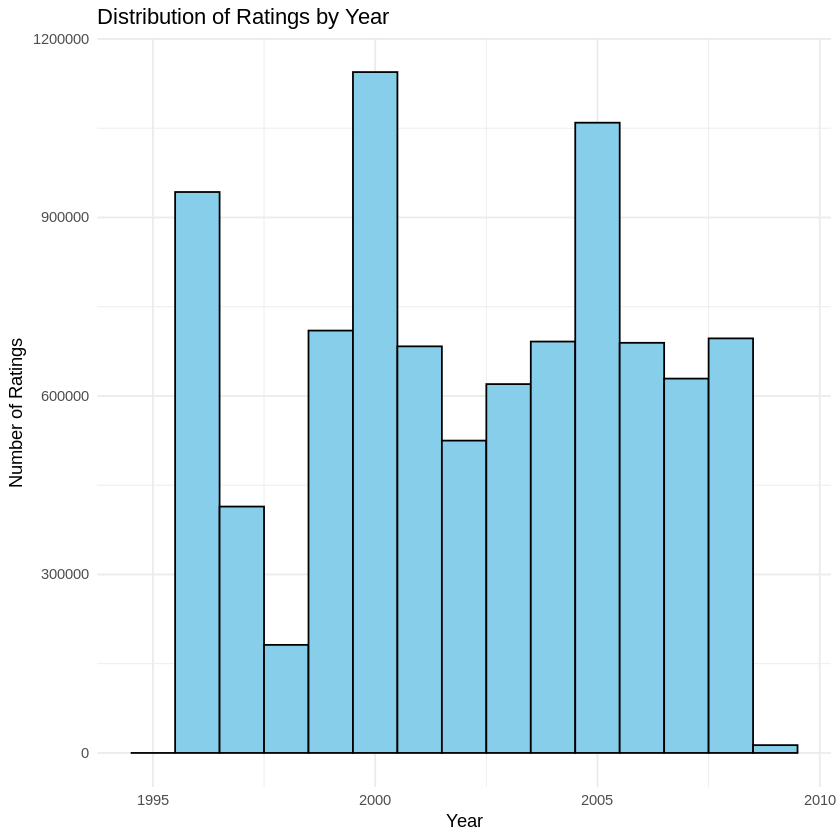

In [55]:
edx$RatingYear <-as.numeric(edx$RatingYear)
str(edx)


# Plot the histogram of RatingYear
ggplot(edx, aes(x = RatingYear)) +
  geom_histogram(binwidth = 1, fill = "skyblue", color = "black") +
  labs(title = "Distribution of Ratings by Year", x = "Year", y = "Number of Ratings") +
  theme_minimal()

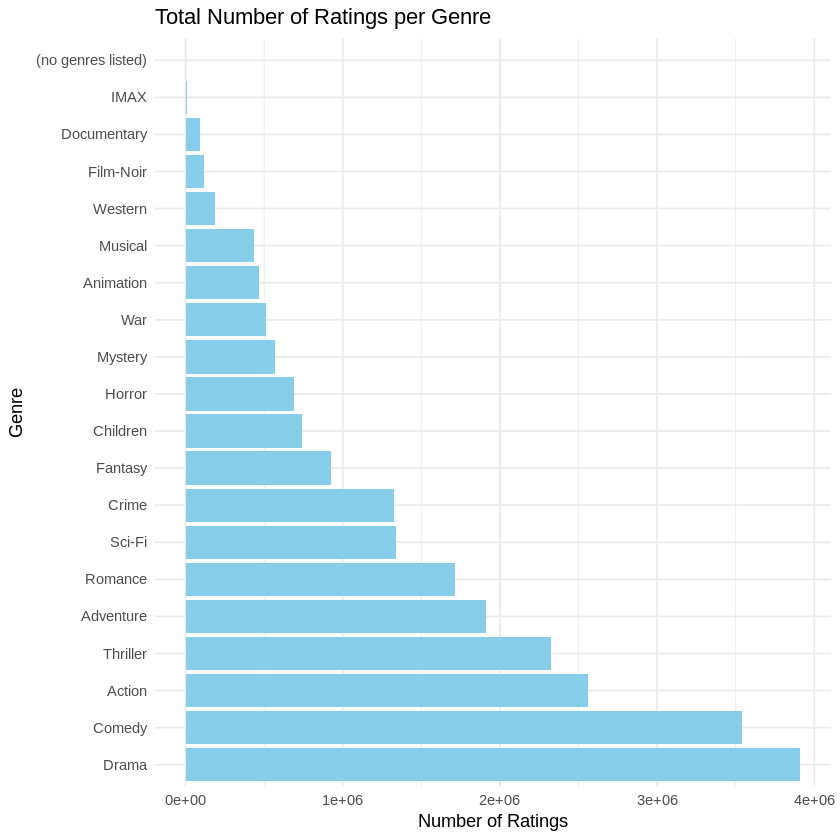

In [57]:
#GENRES

# Separate rows with multiple genres into individual rows for each genre
edx_genres <- edx %>%
  separate_rows(genres, sep = "\\|")  # Split genres by the '|' delimiter

# Summarize the total number of ratings and average rating for each genre
genre_summary <- edx_genres %>%
  group_by(genres) %>%
  summarize(
    Ratings_Sum = n(),
    Average_Rating = mean(rating, na.rm = TRUE),
    .groups = 'drop'
  ) %>%
  arrange(desc(Ratings_Sum))


# Plot the results using a bar chart
library(ggplot2)
ggplot(genre_summary, aes(x = reorder(genres, -Ratings_Sum), y = Ratings_Sum)) +
  geom_bar(stat = "identity", fill = "skyblue") +
  coord_flip() +
  labs(
    title = "Total Number of Ratings per Genre",
    x = "Genre",
    y = "Number of Ratings"
  ) +
  theme_minimal()


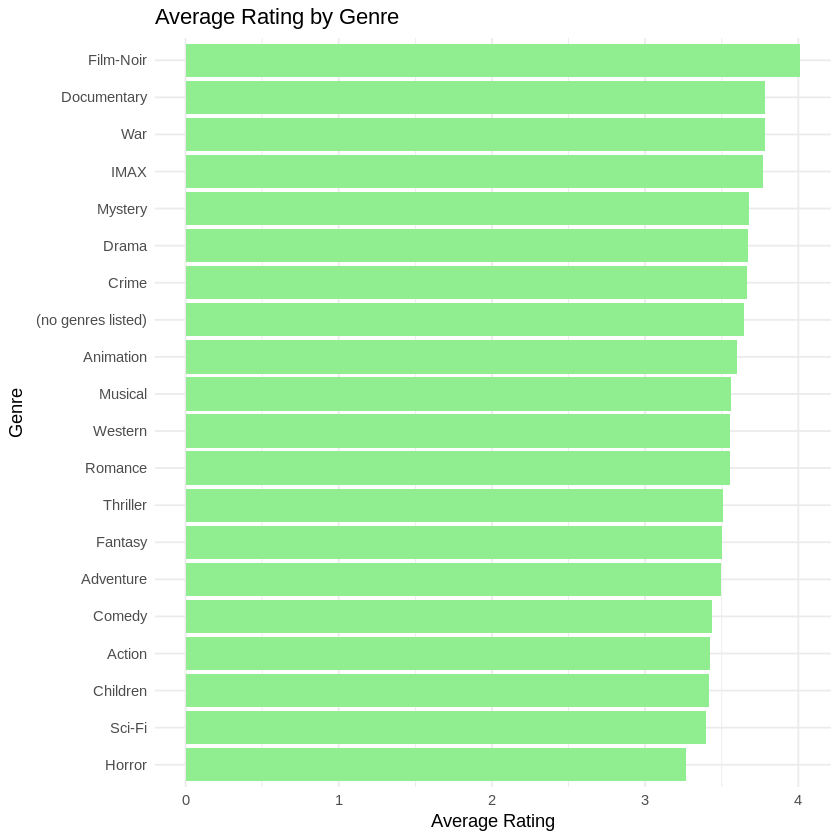

In [59]:
# Load required libraries
if (!require(tidyverse)) install.packages("tidyverse", repos = "http://cran.us.r-project.org")
library(tidyverse)

# Calculate Ratings Sum and Average Rating per Genre, then sort by Average Rating
genre_summary <- edx_genres %>%
  group_by(genres) %>%
  summarize(
    Ratings_Sum = n(),
    Average_Rating = mean(rating, na.rm = TRUE),  # Calculate the average rating
    .groups = 'drop'
  ) %>%
  arrange(desc(Average_Rating))  # Arrange by Average Rating in descending order


# Plot the genres by average rating using a bar chart
library(ggplot2)
ggplot(genre_summary, aes(x = reorder(genres, Average_Rating), y = Average_Rating)) +
  geom_bar(stat = "identity", fill = "lightgreen") +
  coord_flip() +
  labs(
    title = "Average Rating by Genre",
    x = "Genre",
    y = "Average Rating"
  ) +
  theme_minimal()


In [58]:
#MOVIES

# Calculate the number of ratings for each movie
top_movies <- edx %>%
  group_by(movieId, title) %>%
  summarize(num_ratings = n()) %>%
  arrange(desc(num_ratings)) %>%
  slice_head(n = 50)  # Select the top 50 movies

# Display the top 50 movies in a table
top_movies %>%
  col.names = c("Movie ID", "Title", "Number of Ratings")

# Plot the top 50 movies using a bar chart
ggplot(top_movies, aes(x = reorder(title, -num_ratings), y = num_ratings)) +
  geom_bar(stat = "identity", fill = "skyblue") +
  coord_flip() +  # Flip the axes for better readability
  labs(title = "Top 50 Most-Rated Movies", x = "Movie Title", y = "Number of Ratings") +
  theme_minimal()

`summarise()` has grouped output by 'movieId'. You can override using the
`.groups` argument.


ERROR: Error in top_movies %>% col.names = c("Movie ID", "Title", "Number of Ratings"): could not find function "%>%<-"


In [ ]:
# Install and load necessary packages
if (!require("stringr")) install.packages("stringr")
if (!require("dplyr")) install.packages("dplyr")
library(stringr)
library(dplyr)

# Feature Engineering: Extract Year from Movie Title
edx <- edx %>%
  mutate(release_year = as.numeric(str_extract(title, "\\(\\d{4}\\)"))) %>%
  # Handle NAs introduced during year extraction
  mutate(release_year = ifelse(is.na(release_year), 0, release_year)) # Replace NAs with 0

# Generate a table summarizing the most frequent years of movie releases
year_summary <- edx %>%
  count(release_year) %>%
  arrange(desc(n)) %>%
  head(10)

# Display the table
# Use colnames() to assign new column names
colnames(year_summary) <- c("Release Year", "Number of Movies")
print(year_summary)

# Insights: Top 10 most frequent movie release years
cat("Insight: The top 10 most frequent years of movie releases indicate popular eras of filmmaking.")

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `release_year = as.numeric(str_extract(title, "\\(\\d{4}\\)"))`.
Caused by warning:
! NAs introduced by coercion”


  Release Year Number of Movies
1            0          9000055
Insight: The top 10 most frequent years of movie releases indicate popular eras of filmmaking.

In [ ]:
# Split edx Data into Training and Validation Sets
set.seed(1, sample.kind = "Rounding")
index <- createDataPartition(edx$rating, p = 0.8, list = FALSE)
train_set <- edx[index, ]
validation_set <- edx[-index, ]


Warning message in set.seed(1, sample.kind = "Rounding"):
“non-uniform 'Rounding' sampler used”


In [ ]:
# Summary of Training and Validation Sets
training_summary <- data.frame(
  Set = c("Training", "Validation"),
  Rows = c(nrow(train_set), nrow(validation_set)),
  Unique_Users = c(length(unique(train_set$userId)), length(unique(validation_set$userId))),
  Unique_Movies = c(length(unique(train_set$movieId)), length(unique(validation_set$movieId)))
)

# Display the table
print(training_summary)


         Set    Rows Unique_Users Unique_Movies
1   Training 7200045        69878         10647
2 Validation 1800010        69739         10191


In [ ]:
# Train Models on Training Set

mean_rating <- mean(train_set$rating)
baseline_rmse <- sqrt(mean((validation_set$rating - mean_rating)^2))
cat("Baseline RMSE:", baseline_rmse)

cat("\nThe baseline model achieved an RMSE of", round(baseline_rmse, 4),
    ", which serves as a benchmark for evaluating more complex models.")

Baseline RMSE: 1.059733
The baseline model achieved an RMSE of 1.0597 , which serves as a benchmark for evaluating more complex models.

In [ ]:

# Regularized Movie + User Effects Model with Cross-Validation
lambdas <- seq(4, 6, 0.1)
rmses <- sapply(lambdas, function(lambda) {

  # Calculate movie effects (b_i)
  movie_avgs <- train_set %>%
    group_by(movieId) %>%
    summarize(b_i = sum(rating - mean_rating) / (n() + lambda))

  # Calculate user effects (b_u)
  user_avgs <- train_set %>%
    left_join(movie_avgs, by = "movieId") %>%
    group_by(userId) %>%
    summarize(b_u = sum(rating - mean_rating - b_i) / (n() + lambda))

  # Predict ratings on the validation set
  predictions <- validation_set %>%
    left_join(movie_avgs, by = "movieId") %>%
    left_join(user_avgs, by = "userId") %>%
    mutate(pred = mean_rating + b_i + b_u) %>%
    pull(pred)

  return(sqrt(mean((validation_set$rating - predictions)^2)))
})



In [ ]:
#Final Model Evaluation on final_holdout_test


# Train the final model on the entire edx dataset
mean_rating <- mean(edx$rating)

movie_avgs <- edx %>%
  group_by(movieId) %>%
  summarize(b_i = sum(rating - mean_rating) / (n() + lambda))

user_avgs <- edx %>%
  left_join(movie_avgs, by = "movieId") %>%
  group_by(userId) %>%
  summarize(b_u = sum(rating - mean_rating - b_i) / (n() + lambda))

# Predict on the final_holdout_test set
final_predictions <- final_holdout_test %>%
  left_join(movie_avgs, by = "movieId") %>%
  left_join(user_avgs, by = "userId") %>%
  mutate(pred = mean_rating + b_i + b_u) %>%
  pull(pred)

final_rmse <- sqrt(mean((final_holdout_test$rating - final_predictions)^2))
cat("Final RMSE on holdout test set:", final_rmse)


Final RMSE on holdout test set: 0.8648177

In [ ]:
cat("The final model achieved an RMSE of", round(final_rmse, 4),
    "on the final holdout test set, indicating good generalization performance.")

The final model achieved an RMSE of 0.8648 on the final holdout test set, indicating good generalization performance.